# Simple Linear Regression on Crypto

In [97]:
import pandas as pd
import yfinance as yf
from ta import add_all_ta_features
from datetime import datetime, timedelta
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import plotly.express as px
import plotly.graph_objects as go
from tqdm import tqdm

# 1. Get Price Data

In [121]:
def getCryptoPrice(ticker="BTC-USD", n_days=1000):

    # Time periods
    now = datetime.now()

    # How far back to retrieve
    ago = now - timedelta(days=n_days)

    # Designating the Ticker
    crypto = yf.Ticker(ticker)

    # Getting price history
    df = crypto.history(
        start=ago.strftime("%Y-%m-%d"), 
        end=now.strftime("%Y-%m-%d"), 
        interval="1d"
    )

    # Dropping Columns
    df.drop(
        ['Dividends', 'Stock Splits'], 
        axis=1,
        inplace=True
    )

    return df

In [122]:
df = getCryptoPrice(ticker="BTC-USD", n_days=365)

df

,Open,High,Low,Close,Volume
Date,,,,,
2020-10-11,11296.082031,11428.813477,11288.627930,11384.181641,19968627060
2020-10-14,11429.047852,11539.977539,11307.831055,11429.506836,24103426719
2020-10-15,11426.602539,11569.914062,11303.603516,11495.349609,24487233058
2020-10-16,11502.828125,11540.061523,11223.012695,11322.123047,25635480772
2020-10-17,11322.123047,11386.261719,11285.345703,11358.101562,19130430174
...,...,...,...,...,...
2021-10-07,55338.625000,55338.625000,53525.468750,53805.984375,36807860413
2021-10-08,53802.144531,55922.980469,53688.054688,53967.847656,34800873924
2021-10-09,53929.781250,55397.945312,53735.144531,54968.222656,32491211414


## Adding Technical Indicators

In [123]:
df = add_all_ta_features(
    df, 
    open="Open", 
    high="High", 
    low="Low", 
    close="Close", 
    volume="Volume", 
    fillna=True
)

df

/Users/marcosantos/miniforge3/lib/python3.9/site-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/Users/marcosantos/miniforge3/lib/python3.9/site-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



,Open,High,Low,Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,...,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-11,11296.082031,11428.813477,11288.627930,11384.181641,19968627060,7.253529e+09,19968627060,0.363246,0.000000e+00,50.000000,...,-31.837687,0.000000,11384.181641,0.000000,0.000000,0.000000,0.000000,-70.745821,0.000000,0.000000
2020-10-14,11429.047852,11539.977539,11307.831055,11429.506836,24103426719,8.416936e+09,44072053779,0.190981,1.092493e+12,100.000000,...,-43.951014,0.000000,11397.742536,0.000000,1.626846,0.325369,1.301477,0.398142,0.397351,0.398142
2020-10-15,11426.602539,11569.914062,11303.603516,11495.349609,24487233058,1.919178e+10,68559286837,0.279930,1.166752e+12,100.000000,...,-26.508400,0.000000,11428.067610,0.000000,2.987927,0.857881,2.130047,0.576077,0.574424,0.976513
2020-10-16,11502.828125,11540.061523,11223.012695,11322.123047,25635480772,9.583743e+09,42923806065,0.101744,3.656806e+11,65.620319,...,-71.429818,0.000000,11391.293985,0.000000,4.404494,1.567203,2.837291,-1.506927,-1.518397,-0.545130
2020-10-17,11322.123047,11386.261719,11285.345703,11358.101562,19130430174,1.803765e+10,62054236239,0.159167,4.117669e+11,52.239650,...,-61.058422,0.000000,11377.764260,0.000000,3.049977,1.863758,1.186219,0.317772,0.317268,-0.229090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-07,55338.625000,55338.625000,53525.468750,53805.984375,36807860413,2.440586e+12,892554678779,0.120924,3.655005e+13,80.283588,...,-11.958103,4459.662408,50124.380268,25.960381,1.455792,-0.949562,2.405355,-2.809653,-2.849879,372.638140
2021-10-08,53802.144531,55922.980469,53688.054688,53967.847656,34800873924,2.414499e+12,927355552703,0.067120,3.213333e+13,88.485243,...,-12.953636,5652.016820,51190.036585,24.900885,1.075617,-0.544527,1.620144,0.300828,0.300376,374.059966
2021-10-09,53929.781250,55397.945312,53735.144531,54968.222656,32491211414,2.430197e+12,959846764117,0.108012,3.218619e+13,94.539434,...,-6.325701,6801.532790,52252.787989,30.146258,0.245626,-0.386496,0.632122,1.853650,1.836679,382.847379


# 2. Data Transformation/Preprocessing
Changing from time-series data to tabular data.

__E.g.)__ An N% increase in Volume _from N days ago to today_ leads to N% increase in the Open price in the _next_ N day(s). 

In [124]:
def transformData(df, days=1):
    """
    Transforming data into X variables for training.  Uses percent change and 
    multiplies the percentage by 100 rounded to 2 decimal places.
    """
    # Transforming data
    new_df = df.pct_change(
        days
    ).apply(
        lambda x: round(x*100, 2)
    ).replace(
        [np.inf, -np.inf], 
        np.nan
    )
    
    # Dropping Nans
    new_df = new_df.dropna(
        thresh=round(new_df.shape[1]*.7) # If 70% of the values in the row are Nans, drop the whole row
    ).dropna(
        axis=1,
        thresh=round(new_df.shape[0]*.7) # If 70% of the values in the columns are Nans, drop the whole column
    )
    
    # What the percent change is going to be in the next days AKA the Y Variable
    new_df[f'future_{days}_days']= df['Open'].pct_change(
        days
    ).shift(
        -days
    ).apply(
        lambda x: round(x*100, 2)
    )
    
    # Saving the last value in the dataset for later
    last_val = new_df.tail(1).drop(f'future_{days}_days',
                                   axis=1)

    # Dropping the last NaNs from the Y variable
    new_df = new_df.dropna(
        subset=[f'future_{days}_days']
    )

    # Filling in the rest of the NaNs with the most recent value
    new_df = new_df.fillna(method='ffill').dropna()

    return new_df, last_val

In [125]:
new_df, last_val = transformData(df, days=1)

new_df

,Open,High,Low,Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,...,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr,future_1_days
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-03,2.15,1.34,3.15,1.27,-14.60,3.94,6.76,4.00,14.09,10.61,...,10.24,0.15,38.37,-35.75,-9.34,118.90,-39.90,-39.65,3.13,1.26
2020-12-04,1.26,-0.28,-1.21,-3.83,6.08,-6.41,-6.72,-19.13,-94.82,-9.89,...,3.65,0.01,-58.33,-36.51,-12.54,21.63,-401.37,-409.25,-9.25,-3.85
2020-12-05,-3.85,-1.80,-0.57,2.43,-19.57,5.43,5.79,16.05,747.64,-10.51,...,-7.53,0.04,139.68,-97.74,-19.81,38.19,-163.38,-161.41,6.21,2.44
2020-12-06,2.44,1.20,1.66,1.00,-7.15,3.99,5.08,-1.42,20.77,12.11,...,-7.40,0.47,-71.09,-4242.27,-29.94,21.22,-58.99,-58.70,2.46,0.99
2020-12-07,0.99,0.11,0.18,-0.79,6.34,0.42,-5.15,-13.71,-39.10,-11.37,...,-4.88,0.31,97.22,68.72,-43.94,2.82,-179.61,-180.33,-1.93,-0.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-06,4.70,7.19,2.88,7.47,36.69,1.86,5.57,76.53,77.23,1.22,...,67.62,4.08,98.23,-156.25,-31.86,-2436.39,52.68,50.82,9.59,7.48
2021-10-07,7.48,-0.41,6.02,-2.81,-24.94,-1.03,-3.96,-16.38,-29.96,0.54,...,35.65,1.94,-11.18,7.82,-38.77,-17.09,-137.63,-139.57,-3.54,-2.78
2021-10-08,-2.78,1.06,0.30,0.30,-5.45,-1.07,3.90,-44.49,-12.08,10.22,...,26.74,2.13,-4.08,-26.11,-42.66,-32.64,-110.71,-110.54,0.38,0.24


In [126]:
# To be used for current prediction
last_val

,Open,High,Low,Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,...,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2021-10-11,-0.79,2.4,0.47,4.49,9.12,1.21,4.69,58.32,42.94,0.25,...,-70.36,5.01,1.84,12.59,126.48,-724.67,75.07,-1355.05,-1325.5,5.67


# 3. Fit to Linear Model

In [127]:
# Column name
col_name = new_df.columns[-1]

# Train, test, split
X = new_df.drop(col_name, axis=1)

y = new_df[[col_name]]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20
)

In [128]:
# Model object
reg = LinearRegression()

# Fitting
reg.fit(X_train, y_train)

# Getting predictions
preds = reg.predict(X_test)

In [129]:
# Testing current prediction
reg.predict(last_val)

array([[4.52306277]])

## Evaluation

In [130]:
# RMSE
print("RMSE:",mean_squared_error(
    y_test, 
    preds, 
    squared=False
))

# Coefficients
print("Coefficients:\n", reg.coef_)

# Intercept
print("Intercept:", reg.intercept_)

RMSE: 1.613882184767829
Coefficients:
 [[ 9.24740386e-03 -5.11390856e-04 -1.04773065e-02  9.70777186e-01
  -1.51129139e-03 -1.55407119e-02  5.52046009e-03  4.81253886e-05
  -6.83868575e-06  6.09233692e-04 -3.96538219e-06 -3.82964803e-06
   2.38279585e-06 -1.42653789e-02 -5.13943907e-02  3.99996492e-03
  -3.27675773e-01  2.07884809e-01  1.09373275e-01 -7.72150729e-03
  -1.11775727e-04 -2.30641879e+00  1.37236972e+00  9.18661927e-01
  -1.78873923e-02  2.09916025e-05  9.72682464e-02  1.62197429e-01
  -2.61804376e-01 -4.24047721e-03 -4.84056787e-05 -1.18734886e-03
   3.62761262e-05  2.30035112e-05 -3.31787907e-05  1.17485886e-02
  -6.88183051e-02 -1.34220664e-01  3.06496352e-01 -2.94609071e-04
  -2.78532652e-03  5.08564138e-04 -1.17464364e-03 -3.04229465e-03
   6.36297374e-06  8.46633407e-05  2.15204822e-02  1.17737365e-05
   7.44379195e-07  5.26316233e-05 -1.27606308e-04  8.83313708e-05
   1.28777307e-01  1.38019109e-01 -2.56668261e-01  1.92782839e-03
  -5.56900431e-03 -1.04320829e-02  4.

In [131]:
# Making a comparison DF
compare = pd.DataFrame()

compare['actual'] = y_test[col_name].reset_index(drop=True)

compare['preds'] = preds

# Check to see if the predictions at least point in the correct direction
compare['same_direction'] = (
    compare['actual'].apply(lambda x: x>0)==compare['preds'].apply(lambda x: x>0)
)

display(compare)

# How often did predictions land in the same direction as the actual values?
dir_df = compare['same_direction'].value_counts().to_frame()

dir_df

,actual,preds,same_direction
0,3.97,4.133433,True
1,2.45,2.228925,True
2,11.80,11.159799,True
3,-0.81,-0.925067,True
4,-4.55,-5.202162,True
...,...,...,...
58,0.69,0.887841,True
59,-0.11,1.104095,False
60,-0.14,-0.171423,True
61,2.12,2.056844,True


,same_direction
True,60
False,3


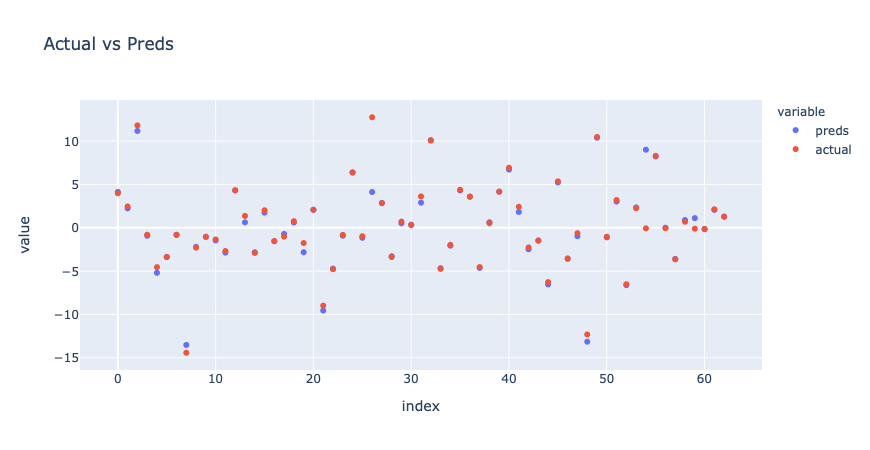

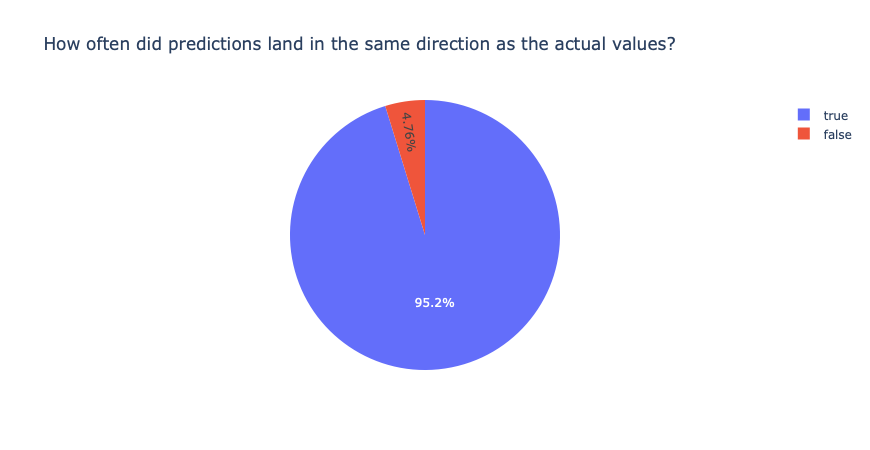

In [132]:
# Visualizing results
fig = px.scatter(
    compare,
    x=compare.index,
    y=['preds', 'actual'],
    title='Actual vs Preds'
)

fig.show()

fig = px.pie(
    dir_df,
    names=dir_df.index,
    values=dir_df['same_direction'],
    title='How often did predictions land in the same direction as the actual values?'
)

fig.show()

# 4. Backtesting Linear Regression

## Helper Functions

In [133]:
def fitModel(new_df):
    """
    Fits model to new data and returns the fitted model to be used for predictions.
    """
    
    # Column name
    col_name = new_df.columns[-1]

    # Variables
    X = new_df.drop(col_name, axis=1)

    y = new_df[[col_name]]
    
    # Model object
    reg = LinearRegression()

    # Fitting
    reg.fit(X, y)
    
    return reg

In [140]:
def getPosition(val, short=True):
    """
    Returns positions with optional short strategy.
    """
    if val>0:
        return 1
    elif val<0 and short:
        return -1
    else:
        return 0

## BackTest Function

In [153]:
def linRegModelBT(ticker, days_to_backtest, days_to_train, short=True, inverse_strat=False):
    """
    Backtests Linear Regression Model based on the given crypto ticker. Range of backtest
    is dependent on days_to_backtest. Training data is dependen on days_to_train.
    Option to short in this strategy is provided as well as inversing the strategy.
    """

    # Getting Data 
    df = getCryptoPrice(
        ticker=ticker, 
        n_days=days_to_backtest+days_to_train
    )

    # Creating a DF for predictions
    pred_df = pd.DataFrame()

    # Iterating through the DF starting from the least amount of days to train on
    for i in tqdm(range(days_to_train, len(df)+1)):

        # Training DF
        train_df = df[i-days_to_train:i]

        # Tranforming the Training DF
        t_df, last_val = transformData(train_df)

        # Fitting to model
        model = fitModel(t_df)

        # Making prediction for the next day
        pred = pd.DataFrame(
            model.predict(last_val), 
            index=last_val.index+pd.offsets.Day(1),
            columns=["prediction"]
        )

        # Appending the prediction to the dataframe
        pred_df = pred_df.append(pred)

    # Getting log returns from the original DF
    pred_df['log_returns'] = df['Open'].tail(len(pred_df)).apply(np.log).diff()

    # Getting positions and compensating for lookahead bias
    pred_df['positions'] = pred_df['prediction'].apply(
        lambda x: getPosition(x, short=short)
    ).shift(1)
    
    if inverse_strat:
        pred_df['positions'] = pred_df['prediction'].apply(
            lambda x: -(x)
        ) 

    # Dropping any Nans
    pred_df.dropna(inplace=True)

    # Performing the backtest
    returns = pred_df['positions'] * pred_df['log_returns']

    # Inversing the log returns and getting daily portfolio balance
    performance = returns.cumsum().apply(np.exp)
    
    return performance

# 5. Performing and Visualizing the Backtest 
With multiple strategies

In [161]:
# Backtest over 1 year and train on about 1 year's worth of data
train_days = 365

range_of_bt = 365

# Usual Backtest
norm_performance = linRegModelBT(
    "BTC-USD", 
    days_to_backtest=range_of_bt, 
    days_to_train=train_days, 
    short=True, 
    inverse_strat=False
)

# Backtesting but without shorting
bullish_only = linRegModelBT(
    "BTC-USD", 
    days_to_backtest=range_of_bt, 
    days_to_train=train_days, 
    short=False, 
    inverse_strat=False
)

# Do the inverse of the strategy
inverse_performance = linRegModelBT(
    "BTC-USD", 
    days_to_backtest=range_of_bt, 
    days_to_train=train_days, 
    short=True, 
    inverse_strat=True
)

# Inverse and bullish
inverse_bullish = linRegModelBT(
    "BTC-USD", 
    days_to_backtest=range_of_bt, 
    days_to_train=train_days, 
    short=False, 
    inverse_strat=True
)

100%|██████████| 362/362 [00:02<00:00, 178.59it/s]


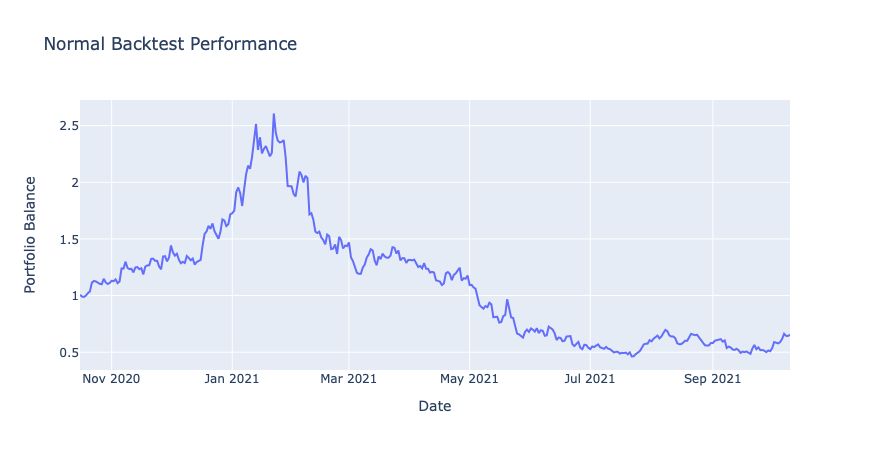

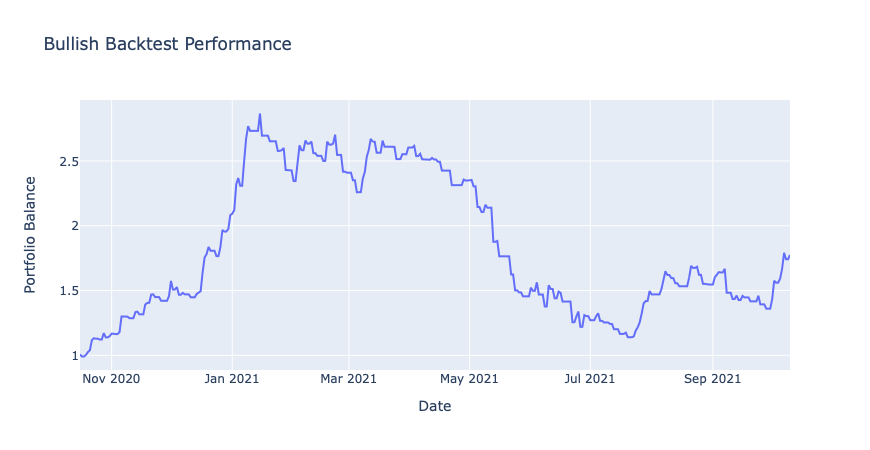

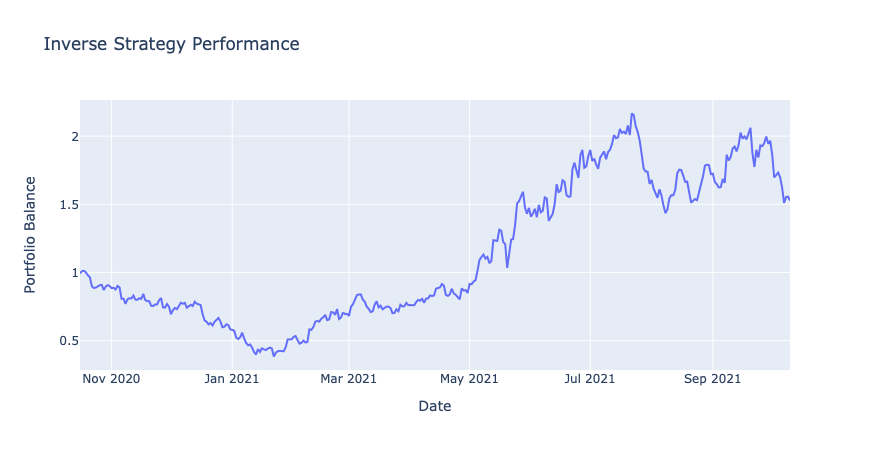

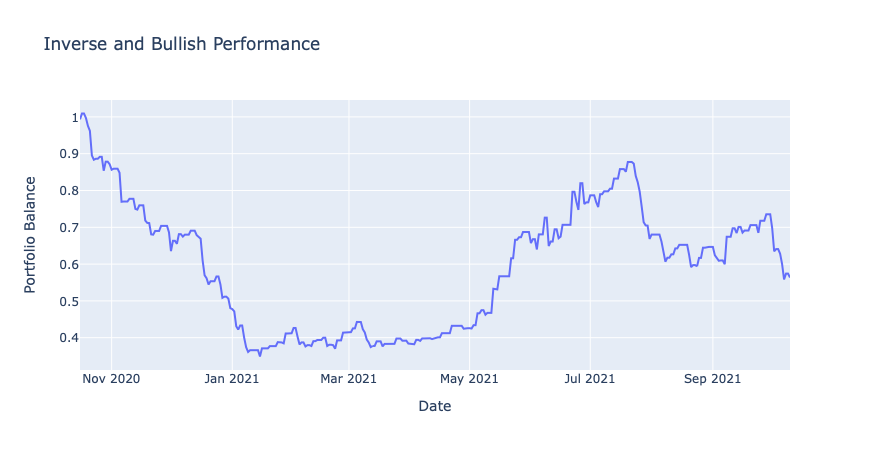

In [162]:
# Visualizing the Different Outcomes
outcomes = {
    "Normal Backtest": norm_performance,
    "Bullish Backtest": bullish_only,
    "Inverse Strategy": inverse_performance,
    "Inverse and Bullish": inverse_bullish
}

for i in outcomes.keys():

    fig = px.line(
        outcomes[i],
        x=outcomes[i].index,
        y=outcomes[i],
        title=f'{i} Performance',
        labels={"y": "Portfolio Balance",
                "ds": "Date"})

    fig.show()